Load model

In [1]:
from torchcore.util import Config
from torchcore.dnn.networks.detectors.build import build_detector
#cfg = 'configs/retinanet/retinanet_resnet50_fpn_coco_mmdet.py'
cfg = 'configs/retinanet/retinanet_resnet50_fpn_coco.py'
config = Config.fromfile(cfg)
model=build_detector(config.model)

device1 = 0
device2 = 1

init from pretrained model


Load pretrained MM detection model

In [2]:
from torchcore.dnn.networks.tools.load_from_mmdetection import load_mm_retinanet
checkpoint= 'retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth'
checkpoint=None
mm_config = 'mmconfigs/retinanet/retinanet_r50_fpn_1x_coco.py'
mm_model=load_mm_retinanet(checkpoint, mm_config, model, return_mm_model=True)

Use load_from_local loader


Load my dataset

In [19]:
from torchcore.data.datasets.build import build_dataloader
from torchcore.util.config import Config
config.dataloader_val.batch_size=2
val_dataset_loader = build_dataloader(config.dataloader_val,distributed=False)
dataset= val_dataset_loader.dataset

48 images are deleted.


In [3]:
json_path = os.path.expanduser('~/data/datasets/Fashionpedia/annotations/instances_attributes_val2020.json')

names = val_dataset_loader.dataset.get_coco_style_names(json_path, with_cat_id=True)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [20]:
%matplotlib inline
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image
from torchcore.tools.visulize_tools import visulize_heatmaps_with_image, visulize_colored_heatmaps_with_image
from torchcore.tools.color_gen import random_colors
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
from torchcore.data.util import set_device

dataset= val_dataset_loader.dataset
score_thresh = 0.6
colors = random_colors(46)
#model.eval()

for i, (inputs, targets) in enumerate(val_dataset_loader):
    #if i!=8:
    #    continue
    #results = model(inputs, targets)
    inputs1 = set_device(inputs, device1)
    targets1 = set_device(targets,device1)
    break

for i, (inputs, targets) in enumerate(val_dataset_loader):
    #if i!=8:
    #    continue
    inputs2 = set_device(inputs, device2)
    targets2 = set_device(targets,device2)
    break
    input, target = dataset[i]
    im = input['data']
    boxes = results['boxes'][0].detach().numpy()
    labels= results['labels'][0].detach().numpy()-1
    scores = results['scores'][0].detach().numpy()

    keep = scores > score_thresh
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]
    draw_plain_boxes(im, boxes)
    draw_single_image(im, boxes, scores, labels, colors, class_names=names)
    #heatmap = class_hp[fpn_layer][0].detach().numpy()
    #heatmap = centerness_hp[fpn_layer][0].detach().numpy()
    #mixim=visulize_colored_heatmaps_with_image(heatmap, im)
    plt.figure(figsize=(8,8))
    plt.imshow(im)

    if i>-1:
        break

In [4]:
import torch

def print_mem(device_list=[0,1], MB=True):
    for d in device_list:
        mem = torch.cuda.memory_allocated(d)
        mem_max = torch.cuda.max_memory_allocated(d)
        if MB:
            mem =int(mem / (1024 * 1024))
            mem_max =int(mem_max/ (1024 * 1024))
        last_str='MB' if MB else ''
        #print('current mem in gpu {}: {} {}'.format(d,mem.item(), last_str))
        #print('max mem in gpu {}: {} {}'.format(d,mem_max.item(), last_str))
        print('mem {}: {} {}'.format(d,mem, last_str))
        print('max mem {}: {} {}'.format(d,mem_max, last_str))

In [5]:
import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist
from mmcv.utils import get_git_hash

from mmdet import __version__
from mmdet.apis import set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import collect_env, get_root_logger

mmconfig='mmconfigs/retinanet/retinanet_r50_fpn_1x_coco.py'
mmcfg = Config.fromfile(mmconfig)
mm_model = build_detector(
        mmcfg.model,
        train_cfg=mmcfg.get('train_cfg'),
        test_cfg=mmcfg.get('test_cfg'))
mm_model.init_weights()

2022-02-22 11:17:52,744 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-02-22 11:17:52,745 - mmcv - INFO - load model from: torchvision://resnet50
2022-02-22 11:17:52,745 - mmcv - INFO - Use load_from_torchvision loader
2022-02-22 11:17:52,858 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-02-22 11:17:52,870 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-02-22 11:17:52,900 - mmcv - INFO - initialize RetinaHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'retina_cls', 'std': 0.01, 'bias_prob': 0.01}}
2022-02-22 11:17:52,952 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-02-22 11:17:52,952 - mmcv - INFO - 
backbone.bn1.weight - tor

In [6]:
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
mm_dataset = build_dataset(mmcfg.data.test)
mm_data_loader = build_dataloader(
    mm_dataset,
    samples_per_gpu=2,
    workers_per_gpu=0,
    dist=False,
    shuffle=False)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [72]:
import numpy as np
result = np.zeros((256,256,3),dtype=np.uint8)
for i in range(3):
    im = np.tile(np.arange(256,dtype=np.uint8),(256,1))
    print(im.shape)
    result[:,:,i]=im
    print(result[:,:,i].shape)


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


0


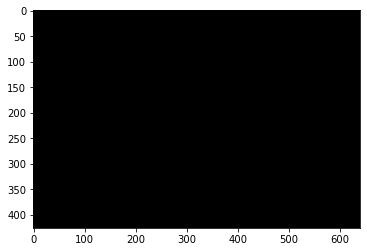

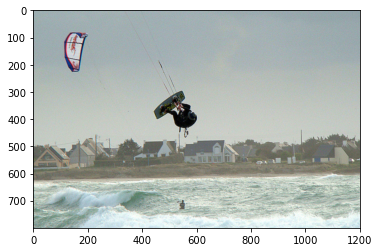

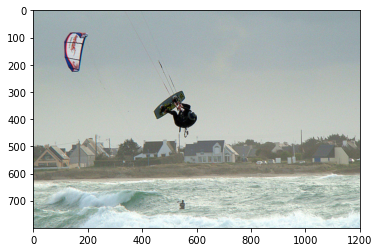

In [76]:
# There is a explaination for resize https://github.com/python-pillow/Pillow/issues/2718
%matplotlib inline
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import numpy as np
im_path ='data/coco/val2017/000000532481.jpg'
pil_im = Image.open(im_path).convert('RGB')
#pil_im = Image.fromarray(result)
np_im = np.array(pil_im)
#cv_im = cv2.imread(im_path)
cv_im = np_im.copy()
#cv_im = cv2.cvtColor(cv_im, cv2.COLOR_BGR2RGB)
cv_resized=cv2.resize(cv_im, (1202,800), interpolation=cv2.INTER_LINEAR)
pil_resized = pil_im.resize((1202,800),Image.BILINEAR)
np_resized = np.array(pil_resized)

diff=(pil_im-cv_im)
print(diff.sum())
plt.imshow(diff)
plt.figure()
plt.imshow(np_resized)
plt.figure()
plt.imshow(cv_resized)


In [26]:
dataset[0]

({'data': <PIL.Image.Image image mode=RGB size=640x426 at 0x7FF001ABC850>,
  'im_path': '/home/dsv/qida0163/data/datasets/COCO/val2017/000000532481.jpg'},
 {'boxes': array([[250.82, 168.26, 320.93, 233.14],
         [435.35, 294.23, 448.81, 302.04],
         [447.44, 293.91, 459.6 , 301.56],
         [460.59, 291.71, 473.34, 300.16],
         [407.07, 287.25, 419.72, 297.11],
         [618.06, 289.31, 629.66, 297.26],
         [512.3 , 294.07, 533.48, 299.64],
         [285.55, 370.56, 297.62, 389.77],
         [ 61.61,  43.76, 107.89, 122.05],
         [238.54, 158.48, 299.7 , 213.87]], dtype=float32),
  'labels': array([ 1,  3,  3,  3,  3,  3,  3,  1, 34, 38]),
  'image_id': 532481})

In [13]:
for o in mm_data_loader:
    if o['img_metas'][0].data[0][0]['ori_filename'] == '000000532481.jpg':
        print(o)
        break

{'img_metas': [DataContainer([[{'filename': 'data/coco/val2017/000000532481.jpg', 'ori_filename': '000000532481.jpg', 'ori_shape': (426, 640, 3), 'img_shape': (800, 1202, 3), 'pad_shape': (800, 1216, 3), 'scale_factor': array([1.878125 , 1.8779342, 1.878125 , 1.8779342], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}]])], 'img': [tensor([[[[ 0.2624,  0.3309,  0.4679,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2967,  0.3652,  0.5022,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.3823,  0.4508,  0.5878,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.3541, -0.4397, -0.5938,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0458, -0.1314, -0.3027,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.1254,  0.0398, -0.1314,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 1.0280,  1.0105,  0.9755,  ...,  0.0000,  0.0000,  

In [6]:
for o in mm_data_loader:
    if o['img_metas'][0].data[0][0]['ori_filename'] == '000000532481.jpg':
        print(o)
        break

{'img_metas': [DataContainer([[{'filename': 'data/coco/val2017/000000532481.jpg', 'ori_filename': '000000532481.jpg', 'ori_shape': (426, 640, 3), 'img_shape': (800, 1202, 3), 'pad_shape': (800, 1216, 3), 'scale_factor': array([1.878125 , 1.8779342, 1.878125 , 1.8779342], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}]])], 'img': [tensor([[[[ 0.2624,  0.3309,  0.4508,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2967,  0.3823,  0.5022,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.3652,  0.4508,  0.5878,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.3541, -0.4397, -0.5938,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0458, -0.1314, -0.3027,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.1254,  0.0227, -0.1314,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 1.0280,  1.0105,  0.9755,  ...,  0.0000,  0.0000,  

In [29]:
((inputs['data'][0]-o['img'][0][0]).max())

tensor(2.3842e-07)

In [8]:
model.backbone.load_state_dict(mm_model.backbone.state_dict(),strict=True)

<All keys matched successfully>

In [7]:
with torch.no_grad():
    for i in range(3):
        model.neck.inner_blocks[i].weight.copy_(mm_model.neck.lateral_convs[i].conv.weight)
        model.neck.layer_blocks[i].weight.copy_(mm_model.neck.fpn_convs[i].conv.weight)
    model.neck.extra_blocks.p6.weight.copy_(mm_model.neck.fpn_convs[3].conv.weight)
    model.neck.extra_blocks.p7.weight.copy_(mm_model.neck.fpn_convs[4].conv.weight)

In [8]:
with torch.no_grad():
    for i in range(4):
        model.det_head.head.cls_head[2*i].weight.copy_(mm_model.bbox_head.cls_convs[i].conv.weight)
        model.det_head.head.bbox_head[2*i].weight.copy_(mm_model.bbox_head.reg_convs[i].conv.weight)
    
    model.det_head.head.cls_head[8].weight.copy_(mm_model.bbox_head.retina_cls.weight)
    model.det_head.head.bbox_head[8].weight.copy_(mm_model.bbox_head.retina_reg.weight)

In [9]:
print_mem()
model = model.to(device1)
mm_model = mm_model.to(device2)
print_mem()

mem 0: 9 MB
max mem 0: 9 MB
mem 1: 9 MB
max mem 1: 9 MB
mem 0: 156 MB
max mem 0: 156 MB
mem 1: 156 MB
max mem 1: 156 MB


In [21]:
from torchcore.data.datasets.convert_my_input_to_mmdet import convert_to_mmdet
print_mem()
model.train()
loss = model(inputs1, targets1)
mm_model.train()
img_meta, gt_boxes,gt_labels = convert_to_mmdet(inputs2, targets2)
#the losses of five layers
mm_loss=mm_model(inputs2['data'],img_meta,gt_bboxes=gt_boxes,gt_labels=gt_labels)
mm_losses_sum={}
for k,v in mm_loss.items():
    mm_losses_sum[k]=sum(v)
mm_loss = mm_losses_sum
print_mem()

mem 0: 1238 MB
max mem 0: 2813 MB
mem 1: 1208 MB
max mem 1: 2735 MB
mem 0: 3520 MB
max mem 0: 3825 MB
mem 1: 3508 MB
max mem 1: 3784 MB


In [22]:
print(loss)
print(mm_loss)

{'loss_objectness': tensor(1.1842, device='cuda:0', grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.7161, device='cuda:0', grad_fn=<DivBackward0>)}
{'loss_cls': tensor(1.1652, device='cuda:1', grad_fn=<AddBackward0>), 'loss_bbox': tensor(0.6982, device='cuda:1', grad_fn=<AddBackward0>)}


In [12]:
print(img_meta)

[{'img_shape': torch.Size([800, 1254]), 'scale_factor': torch.Size([800, 1254]), 'flip': False, 'pad_shape': (1088, 1280, 3), 'batch_input_shape': (1088, 1280)}, {'img_shape': torch.Size([1066, 800]), 'scale_factor': torch.Size([1066, 800]), 'flip': False, 'pad_shape': (1088, 1280, 3), 'batch_input_shape': (1088, 1280)}]


In [18]:
from torchcore.data.util import set_device
model.train()
mm_model.train()
for i, (inputs, targets) in enumerate(val_dataset_loader):
    #results = model(inputs, targets)
    inputs1 = set_device(inputs, device1)
    targets1 = set_device(targets,device1)
    loss = model(inputs1, targets1)
    inputs2 = set_device(inputs, device2)
    targets2 = set_device(targets,device2)
    img_meta = [{'img_shape':imsize,'scale_factor':imscale,'flip':False} for imsize,imscale in zip(inputs2['image_sizes'],inputs2['image_sizes'])]
    for meta in img_meta:
        meta['pad_shape'] = (inputs2['data'].shape[2],inputs2['data'].shape[3],inputs1['data'].shape[1])
    gt_boxes = [t['boxes'] for t in targets2]
    gt_labels = [t['labels']-1 for t in targets2]
    #the losses of five layers
    mm_loss=mm_model(inputs2['data'],img_meta,gt_bboxes=gt_boxes,gt_labels=gt_labels)
    mm_losses_sum={}
    for k,v in mm_loss.items():
        mm_losses_sum[k]=sum(v)
    mm_loss = mm_losses_sum
    loss_sum = sum(loss.values())
    mm_loss_sum = sum(mm_loss.values())
    min_num = 1e-6
    if abs(loss['loss_objectness'].item()-mm_loss['loss_cls'].item()) > min_num or abs(loss['loss_box_reg'].item() -mm_loss['loss_bbox'].item()) > min_num:
        print('{} my obj: {}, bbox: {}'.format(i, loss['loss_objectness'],loss['loss_box_reg']))
        print('{} mm obj: {}, bbox: {}'.format(i, mm_loss['loss_cls'],mm_loss['loss_bbox']))
        print()

    #loss_sum.backward()
    #mm_loss_sum.backward()

    if i>50:
        break

8 my obj: 1.1683757305145264, bbox: 0.7193359136581421
8 mm obj: 1.1683759689331055, bbox: 0.7163808941841125

28 my obj: 1.1695691347122192, bbox: 0.6951692700386047
28 mm obj: 1.1695661544799805, bbox: 0.6951652765274048



In [19]:
print_mem()
loss_sum = sum(loss.values())
mm_loss_sum = sum(mm_loss.values())
print_mem()

mem 0: 6285 MB
max mem 0: 7671 MB
mem 1: 6259 MB
max mem 1: 7612 MB
mem 0: 3516 MB
max mem 0: 7671 MB
mem 1: 3465 MB
max mem 1: 7612 MB


In [20]:
print('mm class: {}'.format(mm_loss['loss_cls']))
print('my class: {}'.format(loss['loss_objectness']))
print('mm box: {}'.format(mm_loss['loss_bbox']))
print('my box: {}'.format(loss['loss_box_reg']))

mm class: 1.6429935693740845
my class: 259.4184875488281
mm box: 0.6266438364982605
my box: 0.6261938214302063


In [53]:
torch.cuda.empty_cache()

In [22]:
print_mem()
model.train()
out = model.backbone(inputs1['data'])
mm_model.train()
mm_out=mm_model.backbone(inputs2['data'])
print_mem()

mem 0: 0 MB
max mem 0: 0 MB
mem 1: 3940 MB
max mem 1: 5131 MB
mem 0: 0 MB
max mem 0: 0 MB
mem 1: 5530 MB
max mem 1: 5540 MB


In [23]:
print_mem()
out = model.neck(out)
mm_out = mm_model.neck(mm_out)
print_mem()

mem 0: 0 MB
max mem 0: 0 MB
mem 1: 5530 MB
max mem 1: 5540 MB
mem 0: 0 MB
max mem 0: 0 MB
mem 1: 5602 MB
max mem 1: 5645 MB


In [24]:

from mmdet.core import (anchor_inside_flags, build_assigner, build_bbox_coder,
                        build_prior_generator, build_sampler, images_to_levels,
                        multi_apply, unmap)
print_mem()
out_head = model.det_head.head(out)
mm_head_out = multi_apply(mm_model.bbox_head.forward_single, mm_out)
print_mem()

mem 0: 0 MB
max mem 0: 0 MB
mem 1: 5602 MB
max mem 1: 5645 MB
mem 0: 0 MB
max mem 0: 0 MB
mem 1: 5802 MB
max mem 1: 5880 MB


In [13]:
print_mem()

img_meta = [{'img_shape':imsize,'scale_factor':imscale,'flip':False} for imsize,imscale in zip(inputs2['image_sizes'],inputs2['image_sizes'])]
for meta in img_meta:
    meta['pad_shape'] = (inputs2['data'].shape[2],inputs2['data'].shape[3],inputs2['data'].shape[1])
gt_boxes = [t['boxes'] for t in targets2]
gt_labels = [t['labels'] for t in targets2]
#the losses of five layers
losses=mm_model(inputs2['data'],img_meta,gt_bboxes=gt_boxes,gt_labels=gt_labels)
loss = model.det_head(inputs1,out,targets1)
print_mem()

1: 1364539392
2: 1364366848
1: 2004828672
2: 2565340672


In [17]:
losses_sum={}
for k,v in losses.items():
    losses_sum[k]=sum(v)
print(losses_sum)

{'loss_cls': tensor(1.2190, device='cuda:2', grad_fn=<AddBackward0>), 'loss_bbox': tensor(0.7460, device='cuda:2', grad_fn=<AddBackward0>)}


In [22]:
loss['loss_box_reg']-losses_sum['loss_bbox']

tensor(5.9605e-08, grad_fn=<SubBackward0>)

In [18]:
loss['loss_objectness']-losses_sum['loss_cls']

tensor(0.0002, grad_fn=<SubBackward0>)

In [23]:
model.train()
out = model.backbone(inputs1['data'])
out = model.neck(out)
out = list(out.values())
out_head = model.det_head.head(out)
loss = model.det_head(inputs1,out,targets1)
print(loss)

{'loss_objectness': tensor(1.1842, device='cuda:0', grad_fn=<DivBackward0>), 'loss_box_reg': tensor(0.7161, device='cuda:0', grad_fn=<DivBackward0>)}


In [24]:
mm_model.train()
mm_out=mm_model.backbone(inputs2['data'])
mm_out=mm_model.neck(mm_out)

In [25]:
for i, (myo, mmo) in enumerate(zip(out, mm_out)):
    if not (myo.cpu()==mmo.cpu()).all():
        print(i)

In [26]:
#mm_head_out=mm_model.bbox_head(mm_out)
from mmdet.core import (anchor_inside_flags, build_assigner, build_bbox_coder,
                        build_prior_generator, build_sampler, images_to_levels,
                        multi_apply, unmap)
mm_head_out = multi_apply(mm_model.bbox_head.forward_single, mm_out)

In [27]:
for i,k in enumerate([2,3,'c5','p6','p7']):
    for j in range(2):
        if not (out_head[i][j].cpu()==mm_head_out[j][i].cpu()).all():
            print(k,i)

In [19]:
mm_model.train()
img_meta = [{'img_shape':imsize,'scale_factor':imscale,'flip':False} for imsize,imscale in zip(inputs2['image_sizes'],inputs2['image_sizes'])]
for meta in img_meta:
    meta['pad_shape'] = (inputs2['data'].shape[2],inputs2['data'].shape[3],inputs2['data'].shape[1])
gt_boxes = [t['boxes'] for t in targets2]
gt_labels = [t['labels']-1 for t in targets2]
#the losses of five layers
mm_loss=mm_model(inputs2['data'],img_meta,gt_bboxes=gt_boxes,gt_labels=gt_labels)
losses_sum={}
for k,v in mm_loss.items():
    losses_sum[k]=sum(v)
print(losses_sum)

{'loss_cls': tensor(1.6122, grad_fn=<AddBackward0>), 'loss_bbox': tensor(0.6437, grad_fn=<AddBackward0>)}


In [20]:
print(float(losses_sum['loss_cls']))

1.1688817739486694


In [30]:
featmap_sizes = [featmap.size()[-2:] for featmap in mm_out]
device = mm_out[0].device

mm_anchor,mm_valid = mm_model.bbox_head.get_anchors(featmap_sizes,img_meta,device=device)
label_channels = mm_model.bbox_head.cls_out_channels if mm_model.bbox_head.use_sigmoid_cls else 1
cls_reg_targets = mm_model.bbox_head.get_targets(
    mm_anchor,
    mm_valid,
    gt_boxes,
    img_meta,
    gt_bboxes_ignore_list=None,
    gt_labels_list=gt_labels,
    label_channels=label_channels,
    return_sampling_results=True)
(labels_list, label_weights_list, bbox_targets_list, bbox_weights_list,
         num_total_pos, num_total_neg, sample_result) = cls_reg_targets

In [31]:
bbox_targets_list_all = torch.cat(bbox_targets_list, dim=1)

In [32]:
bbox_targets_list_all.shape

torch.Size([2, 182403, 4])

In [33]:
bbox_weights_list_all = torch.cat(bbox_weights_list, dim=1)

In [34]:
mm_pos_ind=bbox_weights_list_all[:,:,0].squeeze()>0

In [35]:
mm_bbox_target = bbox_targets_list_all.squeeze()[mm_pos_ind]

In [36]:
mm_bbox_target.shape

torch.Size([593, 4])

In [28]:
anchors = model.det_head.anchor_generater(inputs1, out)
model.det_head.box_matcher.allow_low_quality_match=True
matches = model.det_head.assign_targets_to_anchors(anchors, targets1)

In [37]:
from torchvision.ops.boxes import box_iou
mm_anchor_all = [torch.cat(a) for a in mm_anchor][0]
iou = box_iou(gt_boxes[0], mm_anchor_all)

In [38]:
overlaps=iou
neg_iou_thr=0.4
pos_iou_thr=0.5
min_pos_iou = 0
match_low_quality = True
gt_max_assign_all = True
temp = []
templ = []
num_gts, num_bboxes = overlaps.size(0), overlaps.size(1)

# 1. assign -1 by default
assigned_gt_inds = overlaps.new_full((num_bboxes, ),
                                        -1,
                                        dtype=torch.long)

# for each anchor, which gt best overlaps with it
# for each anchor, the max iou of all gts
max_overlaps, argmax_overlaps = overlaps.max(dim=0)
# for each gt, which anchor best overlaps with it
# for each gt, the max iou of all proposals
gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)

# 2. assign negative: below
# the negative inds are set to be 0
if isinstance(neg_iou_thr, float):
    assigned_gt_inds[(max_overlaps >= 0)
                        & (max_overlaps < neg_iou_thr)] = 0


# 3. assign positive: above positive IoU threshold
pos_inds = max_overlaps >= pos_iou_thr
assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1

if match_low_quality:
    # Low-quality matching will overwrite the assigned_gt_inds assigned
    # in Step 3. Thus, the assigned gt might not be the best one for
    # prediction.
    # For example, if bbox A has 0.9 and 0.8 iou with GT bbox 1 & 2,
    # bbox 1 will be assigned as the best target for bbox A in step 3.
    # However, if GT bbox 2's gt_argmax_overlaps = A, bbox A's
    # assigned_gt_inds will be overwritten to be bbox B.
    # This might be the reason that it is not used in ROI Heads.
    for i in range(num_gts):
        if gt_max_overlaps[i] >= min_pos_iou:
            if gt_max_assign_all:
                max_iou_inds = overlaps[i, :] == gt_max_overlaps[i]
                temp.append(max_iou_inds.nonzero())
                templ.extend(len(max_iou_inds.nonzero())*[i])
                assigned_gt_inds[max_iou_inds] = i + 1
            else:
                assigned_gt_inds[gt_argmax_overlaps[i]] = i + 1
temp = torch.cat(temp).cpu()

#if gt_labels is not None:
#    assigned_labels = assigned_gt_inds.new_full((num_bboxes, ), -1)
#    pos_inds = torch.nonzero(
#        assigned_gt_inds > 0, as_tuple=False).squeeze()
#    if pos_inds.numel() > 0:
#        assigned_labels[pos_inds] = gt_labels[
#            assigned_gt_inds[pos_inds] - 1]
#else:
#    assigned_labels = None



In [39]:
temp.view(-1)

tensor([175260,  95331,  96699,  98067,  95349,  96717,  95385,  96753,  93900,
         95268,  94341,  95709,  95499,  96867, 122367, 143738, 152141])

In [53]:
t1=[31710,  31719,  33972,  35196,  43689,  43698,  44913,  44922,  46110,
         46119,  46218,  46227,  46236,  46236,  46245,  46254,  47334,  47343,
         47442,  47451,  47460,  47460,  47469,  47478,  55863,  55982,  56027,
         56036,  56045, 136287, 137109, 137152, 156943, 157345, 161633]

In [59]:
l1 = [ 6,  6,  5,  5, 11, 11, 11, 11, 13, 13, 12, 12,  7, 12,  7,  7, 13, 13,
        12, 12,  7, 12,  7,  7,  9,  2, 10, 10, 10, 14,  0,  1,  4,  8,  3]

In [92]:
my_pair = {t:l for t,l in zip(t1, l1)}

In [105]:
len(t1)

35

In [106]:
len(set(t1))

33

In [98]:
len(temp)==len(templ)==len(t1)

True

In [93]:
mm_pair = {t:l for t,l in zip(temp.view(-1).numpy(),templ)}

In [95]:
for k in mm_pair:
    if my_pair[k]!=mm_pair[k]:
        print(k, my_pair[k],mm_pair[k])

In [91]:
np.array(l1)[np.argsort(t1)]==np.array(templ)[np.argsort(temp.view(-1))]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [71]:
np.array(templ)==np.array(l1)[np.argsort(l1)]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [68]:
import numpy as np
np.array(l1)[np.argsort(l1)]

array([ 0,  1,  2,  3,  4,  5,  5,  6,  6,  7,  7,  7,  7,  7,  7,  8,  9,
       10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
       14])

In [55]:
s1=set(t1)

In [56]:
s2 = set(temp.reshape(-1).tolist())

In [57]:
s1==s2

True

In [46]:
gt_max_overlaps

tensor([0.8808, 0.7540, 0.7215, 0.7194, 0.7310, 0.3821, 0.6181, 0.1681, 0.7262,
        0.8805, 0.7052, 0.2713, 0.2255, 0.3030, 0.7178], device='cuda:1')

In [34]:
assigned_gt_inds.max()

tensor(15, device='cuda:1')

In [74]:
matched_ind=matches[0].matched_ind

In [76]:
((matched_ind+1).cpu() != assigned_gt_inds.cpu()).nonzero()

tensor([[46236],
        [47460]])

In [104]:
assigned_gt_inds[47460]

tensor(13, device='cuda:1')

In [102]:
matched_ind[47460]

tensor(7, device='cuda:0')

In [80]:
pos_ind = matched_ind >= 0
pos_anchor = anchors[0][pos_ind]
pos_boxes = targets1[0]['boxes'][matched_ind[pos_ind]]
bbox_target = model.det_head.box_coder.encode_once(pos_anchor, pos_boxes)

In [94]:
pos_boxes

tensor([[ 976.7059,  182.2000,  998.2090,  218.3500],
        [ 976.7059,  182.2000,  998.2090,  218.3500],
        [ 976.7059,  182.2000,  998.2090,  218.3500],
        [ 976.7059,  182.2000,  998.2090,  218.3500],
        [ 976.7059,  182.2000,  998.2090,  218.3500],
        [ 976.7059,  182.2000,  998.2090,  218.3500],
        [ 809.8602,  206.2833,  824.9174,  232.2667],
        [ 809.8602,  206.2833,  824.9174,  232.2667],
        [ 748.2321,  272.2167,  760.2245,  295.3833],
        [ 748.2321,  272.2167,  760.2245,  295.3833],
        [ 748.2321,  272.2167,  760.2245,  295.3833],
        [ 748.2321,  272.2167,  760.2245,  295.3833],
        [ 720.1330,  291.6667,  738.6381,  308.4333],
        [ 720.1330,  291.6667,  738.6381,  308.4333],
        [ 824.7675,  288.4333,  839.2918,  304.3333],
        [ 824.7675,  288.4333,  839.2918,  304.3333],
        [ 844.5051,  288.9833,  854.9986,  305.3833],
        [ 844.5051,  288.9833,  854.9986,  305.3833],
        [ 844.5051,  288.983

In [99]:
(sample_result[0].pos_gt_bboxes.cpu()-pos_boxes.cpu())[:,0].nonzero()

tensor([[16],
        [23]])

In [103]:
(sample_result[0].pos_bboxes.cpu()-pos_anchor.cpu())[:,0].nonzero()

tensor([], size=(0, 1), dtype=torch.int64)

In [108]:
anchor_box.unsqueeze(0)

tensor([[824., 280., 856., 312.]])

In [109]:
from torchvision.ops.boxes import box_iou
mm_box = sample_result[0].pos_gt_bboxes.cpu()[16].unsqueeze(0)
my_box = pos_boxes.cpu()[16].unsqueeze(0)
anchor_box = pos_anchor.cpu()[16].unsqueeze(0)
print(box_iou(mm_box, anchor_box))
print(box_iou(my_box, anchor_box))

tensor([[0.2255]])
tensor([[0.1681]])


In [100]:
pos_boxes[16]

tensor([844.5051, 288.9833, 854.9986, 305.3833], device='cuda:0')

In [101]:
sample_result[0].pos_gt_bboxes[16]

tensor([824.7675, 288.4333, 839.2918, 304.3333], device='cuda:1')

In [102]:
targets1

[{'boxes': tensor([[   0.0000,  348.7667,   64.6762,  420.6667],
          [  64.1099,  345.6500,  173.7247,  411.8833],
          [ 756.2770,  345.8000,  839.3584,  375.0167],
          [ 219.1963,  197.7500,  697.0974,  519.5500],
          [ 846.0209,  317.2000, 1059.7539,  465.5500],
          [ 809.8602,  206.2833,  824.9174,  232.2667],
          [ 976.7059,  182.2000,  998.2090,  218.3500],
          [ 844.5051,  288.9833,  854.9986,  305.3833],
          [ 157.0684,  322.7833,  256.5728,  562.3667],
          [ 675.7441,  348.5667,  716.0688,  371.1500],
          [ 801.2988,  344.1500,  892.1254,  375.2833],
          [ 748.2321,  272.2167,  760.2245,  295.3833],
          [ 824.7675,  288.4333,  839.2918,  304.3333],
          [ 720.1330,  291.6667,  738.6381,  308.4333],
          [ 715.0195,  337.6833,  800.5660,  374.5000]], device='cuda:0'),
  'labels': tensor([ 3,  3,  3,  8,  8, 10, 10, 10,  1,  3,  3, 10, 10, 10,  3],
         device='cuda:0'),
  'image_id': 393226}]

In [86]:
(mm_pos_ind.cpu() == pos_ind.cpu()).all()

tensor(True)

In [83]:
bbox_target.cpu()-mm_bbox_target.cpu()

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        

In [41]:
matched_ind.min()

tensor(-2, device='cuda:0')

In [52]:
valid_mm_match=labels_list_all[label_weights_list_all>0]

In [53]:
valid_match = matched_ind[matched_ind>=-1]

In [54]:
valid_mm_match[valid_mm_match==80]=-1

In [60]:
valid_mm_match.max()

tensor(9, device='cuda:1')

In [43]:
labels_list_all.max()

tensor(80, device='cuda:1')

In [48]:
(label_weights_list[0]==1).sum()

tensor(136478)

In [24]:
img_meta

[{'img_shape': torch.Size([800, 1201]),
  'scale_factor': torch.Size([800, 1201]),
  'flip': False,
  'pad_shape': (800, 1216, 3),
  'batch_input_shape': (800, 1216)}]

In [22]:
featmap_sizes

[torch.Size([100, 152]),
 torch.Size([50, 76]),
 torch.Size([25, 38]),
 torch.Size([13, 19]),
 torch.Size([7, 10])]

In [23]:
#out_head_v=list(out_head.values())


In [36]:
model.det_head.anchor_generater.cell_anchors[0]

tensor([[-22.6274, -11.3137,  22.6274,  11.3137],
        [-28.5088, -14.2544,  28.5088,  14.2544],
        [-35.9188, -17.9594,  35.9188,  17.9594],
        [-16.0000, -16.0000,  16.0000,  16.0000],
        [-20.1587, -20.1587,  20.1587,  20.1587],
        [-25.3984, -25.3984,  25.3984,  25.3984],
        [-11.3137, -22.6274,  11.3137,  22.6274],
        [-14.2544, -28.5088,  14.2544,  28.5088],
        [-17.9594, -35.9188,  17.9594,  35.9188]], device='cuda:1')

In [40]:
mm_model.bbox_head.prior_generator.base_anchors[0]

tensor([[-22.6274, -11.3137,  22.6274,  11.3137],
        [-28.5088, -14.2544,  28.5088,  14.2544],
        [-35.9188, -17.9594,  35.9188,  17.9594],
        [-16.0000, -16.0000,  16.0000,  16.0000],
        [-20.1587, -20.1587,  20.1587,  20.1587],
        [-25.3984, -25.3984,  25.3984,  25.3984],
        [-11.3137, -22.6274,  11.3137,  22.6274],
        [-14.2544, -28.5088,  14.2544,  28.5088],
        [-17.9594, -35.9188,  17.9594,  35.9188]])

In [41]:
mm_anchor_all = [torch.cat(a) for a in mm_anchor]

In [43]:
(anchors[1].cpu()-mm_anchor_all[1].cpu()==0).all()

tensor(True)

In [30]:
mm_anchor_all[0]

tensor([[ -22.6274,  -11.3137,   22.6274,   11.3137],
        [ -28.5088,  -14.2544,   28.5088,   14.2544],
        [ -35.9188,  -17.9594,   35.9188,   17.9594],
        ...,
        [ 970.9807,  405.9613, 1333.0193, 1130.0387],
        [ 923.9299,  311.8599, 1380.0701, 1224.1401],
        [ 864.6497,  193.2994, 1439.3503, 1342.7006]])

In [72]:
for i in range(5):
    print(mm_anchor[0][i].shape)

torch.Size([136800, 4])
torch.Size([34200, 4])
torch.Size([8550, 4])
torch.Size([2223, 4])
torch.Size([630, 4])


In [62]:
mm_anchor_all[0].shape

torch.Size([182403, 4])

In [17]:
print(inputs['data'].shape)
for k,v in out.items():
    print(k,v.shape)

torch.Size([1, 3, 800, 1216])
2 torch.Size([1, 256, 100, 152])
3 torch.Size([1, 256, 50, 76])
p5 torch.Size([1, 256, 25, 38])
p6 torch.Size([1, 256, 13, 19])
p7 torch.Size([1, 256, 7, 10])


In [57]:
for k,v in out_head.items():
    print(k,out_head[k][0].shape)
out_head['2'][0].shape

2 torch.Size([1, 720, 100, 152])
3 torch.Size([1, 720, 50, 76])
c5 torch.Size([1, 720, 25, 38])
p6 torch.Size([1, 720, 13, 19])
p7 torch.Size([1, 720, 7, 10])


torch.Size([1, 720, 100, 152])

In [16]:
model.eval()
x=model.backbone.conv1(inputs['data'])
x = model.backbone.bn1(x)
x = model.backbone.relu(x)
x = model.backbone.maxpool(x)
x = model.backbone.layer1(x)
x = model.backbone.layer2[0].conv1(x)
x = model.backbone.layer2[0].bn1(x)

mm_model.eval()
mx=mm_model.backbone.conv1(inputs['data'])
mx = mm_model.backbone.norm1(mx)
mx = mm_model.backbone.relu(mx)
mx = mm_model.backbone.maxpool(mx)
mx = mm_model.backbone.layer1(mx)
mx = mm_model.backbone.layer2[0].conv1(mx)
mx = mm_model.backbone.layer2[0].norm1(mx)


In [17]:
(mx==x).all()

tensor(True, device='cuda:0')

In [28]:
model.backbone.layer2[0].bn1.training
#model.backbone.bn1.training

False

In [29]:
mm_model.backbone.layer2[0].norm1.training
#mm_model.backbone.norm1.training

False

In [30]:
mm_model.backbone.norm_eval

True